In [1378]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from matplotlib import pyplot as plt
from matplotlib import gridspec

import scipy

import datetime
from collections import OrderedDict

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, RBF, ConstantKernel as C
np.random.seed(1)
%matplotlib inline

In [963]:
class Parser:
    def __init__(self):
        index = pd.date_range(datetime.datetime(1982,1,1),datetime.datetime(2017,1,1), freq='MS')
        Dummy = np.zeros(shape=index.shape)
        data={'Dummy':Dummy}
        self.Data = pd.DataFrame(index=index,data=data)
    def Read_Meta(self,Path,thresh=0):
        self.thresh=thresh
        Names = []
        Start = []
        End = []
        Lat = []
        Long = []
        Break = []
        File = []
        offset = []
        for Dir,subdir,files in os.walk(Path):
            for file in files:
                Temp = open(Dir+file).readlines()
                i = 0
                for line in Temp:
                    if line [0]!= 'C':
                        Break.append(i-3)
                        File.append(file)
                        break
                    else:
                        if "STATION NAME: " in line:
                            Names.append(line.split(': ')[1].split(' \n')[0])
                        elif "COVERING PERIOD: " in line:
                            Cov = line.split(': ')[1].split('\n')[0].split(' ')
                            Start.append(Cov[0])
                            End.append(Cov[1])
                        elif "LATITUDE: " in line:
                            Lat.append(float(line.split(': ')[1].split('\n')[0]))
                        elif "LONGITUDE: " in line:
                            Long.append(float(line.split(': ')[1].split('\n')[0]))
                        elif "MEASUREMENT UNIT: " in line:
                            if "ppm" in line:
                                offset.append(1000)
                            else:
                                offset.append(1)
                        i +=1
        Meta = {'Name':Names,'Start':Start,'End':End,'Lat':Lat,'Long':Long,'Break':Break,'File':File,'Offset':offset}
        Meta = pd.DataFrame(data=Meta)
        Meta['Start'] = pd.to_datetime(Meta['Start'])
        Meta['End'] = pd.to_datetime(Meta['End'])
        Meta['Span'] = Meta['End']-Meta['Start']
        self.Meta=Meta
        
    def Read_Data(self,Dir,min_years=1):
        self.keep = []
        for Site in self.Meta['Name'].unique():
            Var = Site
            Var2=Var
            Recs=self.Meta.loc[self.Meta['Name']==Site].sort_values(by='Span',ascending=False)
            i = 0
            for file in Recs['File']:
                if i != 0:
                    Var=Var+'_'+str(i)
                skip = Recs['Break'].loc[Recs['File']==file].values[0]
                df = pd.read_table(Dir+file,skiprows = skip,names=["DATE","TIME","dummy1","dummy2",Var,"ND","SD","F","CS","REM"],
                                   delim_whitespace=True)
                df['date']=pd.to_datetime(df['DATE'])
                df = df.set_index(df['date'])
                try:
                    df = df.resample('MS').ffill().reindex(pd.date_range(df.index[0],df.index[-1],freq='MS'))
                    if ((df.index.max()-df.index.min()).days)>=(min_years*365):
                        offset = Recs['Offset'].loc[Recs['File']==file].values[0]
                        if offset != 1:
                            df[Var] = df[Var]*offset
                        self.Data = pd.merge(self.Data,df[Var].to_frame(),left_index=True,right_index=True,how='outer')
                        if i == 0:
                            self.keep.append(file)
                except:
                    print('Error, Dropping File: '+file)
                i +=1
                Var=Var2
        
        self.Data.drop('Dummy',inplace=True,axis=1)
        self.Duplicates()
        self.Data[self.Data<self.thresh]=np.nan
        self.Aggregate()
        
    def Duplicates(self):
        for var in self.Data:
            if '_' in var:
                Site = var.split('_')
                self.Data.loc[self.Data[Site[0]]==np.nan,[Site[0]]]=self.Data[Site[0]+'_'+Site[1]]
                self.Data.drop(var,inplace=True,axis=1)
        self.Meta = self.Meta[self.Meta['File'].isin(self.keep)]
        self.Meta.reset_index()
        self.Meta.set_index('Name',drop=True,inplace=True)
        
    def Aggregate(self):
        self.Yearly = self.Data.resample('A').mean()
        self.Yearly_std = self.Data.resample('A').std()
        self.Yearly_ct = self.Data.resample('A').count()
        self.Monthly = self.Data.groupby(self.Data.index.month).mean()
        self.Monthly_std = self.Data.groupby(self.Data.index.month).std()
        self.Monthly_ct = self.Data.groupby(self.Data.index.month).count()

CH4_13 = Parser()
CH4_13.Read_Meta('C:/Users/wesle/CompsProj/13ch4/monthly/',thresh=-1000)
CH4_13.Read_Data('C:/Users/wesle/CompsProj/13ch4/monthly/')
        
CH4 = Parser()
CH4.Read_Meta('C:/Users/wesle/CompsProj/ch4/monthly/')
CH4.Read_Data('C:/Users/wesle/CompsProj/ch4/monthly/',min_years=5)



In [961]:
def Lat_Split(Meta):
    Arctic = (Meta.index[Meta['Lat']>66.5]).values
    Mid_Lats_N = (Meta.index[(Meta['Lat']<66.5)&(Meta['Lat']>23.5)]).values
    Tropics = (Meta.index[(Meta['Lat']<23.5)&(Meta['Lat']>-23.5)]).values
    Mid_Lats_S = (Meta.index[(Meta['Lat']<-23.5)&(Meta['Lat']>-66.6)]).values
    Antarctic = (Meta.index[Meta['Lat']<-66.5]).values
    return(Arctic,Mid_Lats_N,Tropics,Mid_Lats_S,Antarctic)


def Label_Duplicates(ax):
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    return(handle_list,label_list)

def Error_Bar_Plot(Data,Columns,colors,labels,title):
    fig,ax=plt.subplots(1,1,figsize=(18,14))
    for col,color,label in zip(Columns,colors,labels):
        if len(col) > 1: 
            plt.errorbar(Data[col[0]].index,Data[col].mean(axis=1),yerr=Data[col].std(axis=1)/(Data[col].count(axis=1)**.5),
                     color=color,label=label+'$\pm$ 1 SE',capsize=10)
        else:
            plt.plot(Data[col[0]].index,Data[col].mean(axis=1),color=color,label=label)
    handle_list, label_list=Label_Duplicates(ax)
    plt.legend(handle_list, label_list)
    plt.title(title,fontsize =22)    
    plt.show()
    
def Profile(klass):
    Data = klass.Data
    Meta = klass.Meta
    Meta = Meta.sort_values(by='Lat',axis=0)
    Lat_Profile = np.empty(shape = (len(Meta)),dtype=[('Lat', np.float64), ('mean', np.float64), 
                                                      ('std', np.float64),('SE', np.float64)])
    Lat_Profile_yr = np.empty(shape = (len(Meta),klass.Yearly.shape[0]),dtype=[('Lat', np.float64), ('mean', np.float64), 
                                                      ('std', np.float64),('SE', np.float64)])
    Lat_Profile_mo = np.empty(shape = (len(Meta),klass.Monthly.shape[0]),dtype=[('Lat', np.float64), ('mean', np.float64), 
                                                      ('std', np.float64),('SE', np.float64)])
    for i,station in enumerate(Meta.index):
        Lat_Profile['Lat'][i]=Meta.loc[station]['Lat']
        Lat_Profile['mean'][i]=np.nanmean(Data[station])
        Lat_Profile['std'][i]=np.nanstd(Data[station])
        Lat_Profile['SE'][i]=np.nanstd(Data[station])/(np.count_nonzero(np.isnan(Data[station]))**.5)
        
        
        Lat_Profile_yr['Lat'][i,:]=Meta.loc[station]['Lat']
        Lat_Profile_yr['mean'][i,:]=klass.Yearly[station].values
        Lat_Profile_yr['std'][i,:]=klass.Yearly_std[station].values
        Lat_Profile_yr['SE'][i,:]=klass.Yearly_std[station].values/klass.Yearly_ct[station].values
        
        Lat_Profile_mo['Lat'][i,:]=Meta.loc[station]['Lat']
        Lat_Profile_mo['mean'][i,:]=klass.Monthly[station].values
        Lat_Profile_mo['std'][i,:]=klass.Monthly_std[station].values
        Lat_Profile_mo['SE'][i,:]=klass.Monthly_std[station].values/klass.Monthly_ct[station].values
        
    return(Lat_Profile,Lat_Profile_yr)


# Ploting Parametres

In [1227]:
TitleFont=22
AxisLabelFont = 16
LegendFont = 14

Red = (1,0,0,.75)
Green = (0,1,0,.75)
Blue = (0,0,1,.75)
LightGrey = (0,0,0,.25)

# Figure 2 - Distribution of study sites

[ 1.039   1.0065  1.0175]


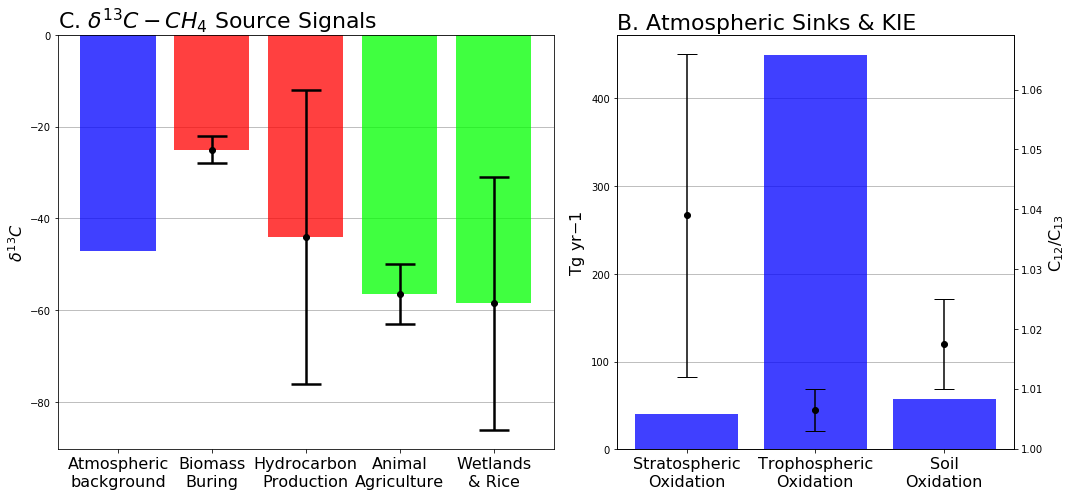

In [1223]:
def Intro_Plot():
    plt.rcParams['axes.axisbelow'] = True
    
    fig = plt.figure(figsize=(15,7))
    gs = gridspec.GridSpec(1, 2, width_ratios=[5, 4]) 

## Plot 1
    
#     ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[0,0])

    Sinks = [40,450,58]
    Index = np.arange(0,len(Sinks))
    Sinks = np.asanyarray(Sinks)
    System = ['Stratospheric\nOxidation','Trophospheric\nOxidation','Soil\nOxidation']
    System = np.asanyarray(System)
    Color = [Blue,Blue,Green]
    barlist = ax2.bar(Index,Sinks,color = Blue)
    plt.sca(ax2)
    plt.xticks(Index, System,fontsize=AxisLabelFont)
    
    Sinks_High = [1.066,1.010,1.025]
    Sinks_Low = [1.012,1.003,1.010]
    Index = np.arange(0,len(Sinks_High))
    Sinks_Low = np.asanyarray(Sinks_Low)
    Sinks_Hight = np.asanyarray(Sinks_High)
    Sinks_Mid = (Sinks_High+Sinks_Low)/2
    ax2.set_ylabel('Tg yr${-1}$',fontsize = AxisLabelFont)
    ax2_2 = ax2.twinx()
    ax2_2.errorbar(Index,Sinks_Mid,yerr=(Sinks_High-Sinks_Low)/2,fmt='o',color='black',capsize=10)
    print(Sinks_Mid)#-(Sinks_High-Sinks_Low))
    ax2_2.set_ylabel('C$_{12}$/C$_{13}$',fontsize = AxisLabelFont)
    ax2.yaxis.grid(zorder=0)
    plt.sca(ax2_2)
#     plt.yticks(np.linspace(ax2_2.get_yticks()[0], ax2_2.get_yticks()[-1], len(ax2.get_yticks())))

## Plot 3
    
    Sinks_High = [-47,-22,-12,-50,-31]
    Sinks_Low = [-47,-28,-76,-63,-86]
    Index = np.arange(0,len(Sinks_High))
    Sinks_Low = np.asanyarray(Sinks_Low)
    Sinks_High = np.asanyarray(Sinks_High)
    Sinks_Mid = (Sinks_High+Sinks_Low)/2
    System = ['Atmospheric\nbackground','Biomass\nBuring','Hydrocarbon\nProduction','Animal\nAgriculture','Wetlands\n& Rice']
    System = np.asanyarray(System)
    Color = [Blue,Red,Red,Green,Green]
    ax3.yaxis.grid(zorder=0)
    plt.sca(ax3)
    for pos, y, err, color in zip(Index, Sinks_Mid, (Sinks_High-Sinks_Low)/2, Color):
        barlist = ax3.bar(pos,y,color=color)
        if pos != 0:
            ax3.errorbar(pos, y, err, lw=2.5, capsize=15, capthick=2.5, color='black',fmt='o')
    plt.xticks(Index, System,fontsize=AxisLabelFont)
    
    
    
        
    ax3.set_ylabel('${\delta^{13} C}$',fontsize = AxisLabelFont)
    
    ax1.set_ylim(0,-65)
    ax1.set_title('A. ${\delta^{13} C - CH_{4}}$ Ratios', loc ='left',fontsize = TitleFont)
    ax2.set_title('B. Atmospheric Sinks & KIE', loc ='left',fontsize = TitleFont)
    ax3.set_title('C. ${\delta^{13} C - CH_{4}}$ Source Signals', loc ='left',fontsize = TitleFont)
    fig.tight_layout()
    
Intro_Plot()

C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


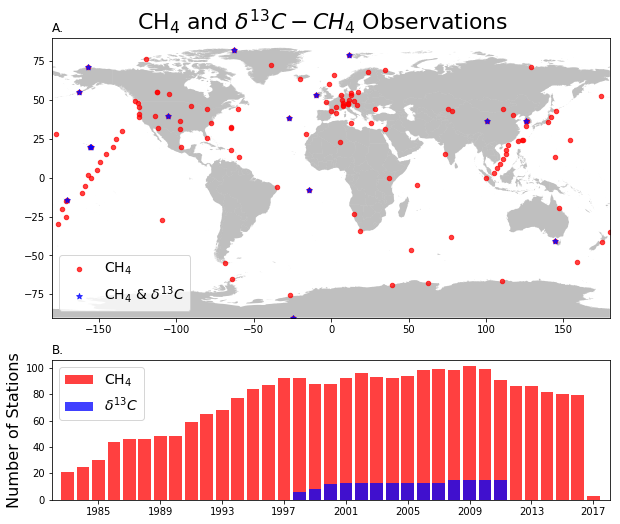

In [1230]:
World = gpd.read_file('TM_WORLD_BORDERS-0.3.shp')

geometry = [Point(xy) for xy in zip(CH4.Meta.Long, CH4.Meta.Lat)]
df = CH4.Meta.drop(['Long', 'Lat'], axis=1)
crs = {'init': 'epsg:4326'}
CH4_gpd = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

geometry = [Point(xy) for xy in zip(CH4_13.Meta.Long, CH4_13.Meta.Lat)]
df = CH4_13.Meta.drop(['Long', 'Lat'], axis=1)
crs = {'init': 'epsg:4326'}
CH4_13_gpd = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)


# fig, ((ax1, ax2)) = plt.subplots(nrows=2, ncols=1, figsize=(12, 16))

fig = plt.figure(figsize=(10, 8.5)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1.5]) 

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[1])

World.plot(ax=ax1,color=LightGrey)
CH4_gpd.plot(ax=ax1,color = Red,markersize=20,label='CH$_4$')
CH4_13_gpd.plot(ax=ax1,color = Blue,marker = '*',label='CH$_4$ & ${\delta^{13} C}$')

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels,loc=3,fontsize = LegendFont)
ax1.set_ylim(-90.1,90.1)
ax1.set_xlim(-180.1,180.1)
ax1.set_title('A.',loc='left')

ax2.bar(CH4.Yearly.count(axis=1).index-1,CH4.Yearly.count(axis=1),width=300,color=Red,label='CH$_4$')
ax2.bar(CH4_13.Yearly.count(axis=1).index-1,CH4_13.Yearly.count(axis=1)
        ,width=300,color=Blue,label='${\delta^{13} C}$')
ax2.set_xlim('1982-01-01','2018-1-31')
ax2.set_title('B.',loc='left')
ax2.set_ylabel('Number of Stations',fontsize = AxisLabelFont)
ax2.xaxis_date()

# print(CH4_13.Meta.sort_values('Lat'))

plt.legend(fontsize = LegendFont)
plt.suptitle('CH$_4$ and ${\delta^{13} C-CH_4}$ Observations',y=.93,fontsize=22)
plt.show()

# Figure 2 - Global trend in CH$_4$ Concentrations

6.17025851921 1782.92885866
LinregressResult(slope=6.1702585192129611, intercept=1782.928858661204, rvalue=0.95138542600915643, pvalue=6.3101489779418429e-18, stderr=0.353123522150881)
(5.7514393162547197, 1808.4156546449035, 4.6897905923182694, 6.5811689255584191)


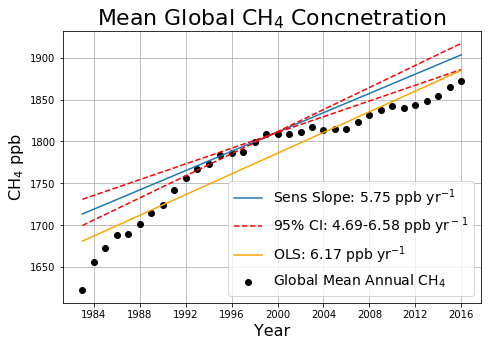

-0.013672450518 -47.1829327029
LinregressResult(slope=-0.013672450518041326, intercept=-47.182932702862615, rvalue=-0.79775042085875802, pvalue=0.00062916598255470188, stderr=0.0029833019234345678)
(-0.01184829059829203, -47.161644230769241, -0.021113390313389227, -0.0048649616256741168)


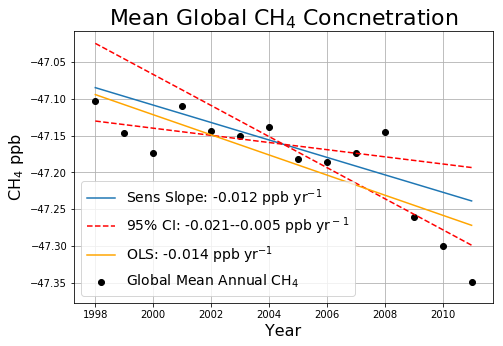

In [1221]:
def Slope_Analysis(Data,Period,loc,r):
    MeanAnnual = Data.mean(axis=1).loc[Period[0]:Period[1]].resample('AS').mean()
    # MeanAnnual = CH4.Data.resample('AS').mean().loc['1984-01-01':'2016-12-31']#
    Line = np.arange(0,MeanAnnual.shape[0])
    Line = Line-Line[-1]/2
    m,b = np.polyfit(Line,MeanAnnual.values,1)
    Linear_Trend = m*Line+b
    print(m,b)

    TS = scipy.stats.mstats.theilslopes(MeanAnnual.values,Line,alpha=0.95)
    Mean_TS = TS[0]*Line + TS[1]
    Lower_TS = TS[2]*Line + TS[1]
    Upper_TS = TS[3]*Line + TS[1]

    print(scipy.stats.linregress(Line,MeanAnnual))
    print(TS)

    plt.figure(figsize = (7.5,5))
    plt.scatter(MeanAnnual.index,MeanAnnual,label = 'Global Mean Annual CH$_4$',color = 'black')
    plt.plot(MeanAnnual.index,Mean_TS,label = 'Sens Slope: '+str(np.round(TS[0],r))+' ppb yr$^{-1}$')
    plt.plot(MeanAnnual.index,Lower_TS,
             label = '95% CI: '+str(np.round(TS[2],r))+'-'+str(np.round(TS[3],r))+' ppb yr$^-$$^1$',
             color = 'red',linestyle = '--')
    plt.plot(MeanAnnual.index,Upper_TS,color = 'red',linestyle = '--')
    plt.plot(MeanAnnual.index,Linear_Trend,color='orange', label='OLS: '+str(np.round(m,r))+' ppb yr$^{-1}$')
    plt.title('Mean Global CH$_4$ Concnetration',fontsize = TitleFont)
    plt.ylabel('CH$_4$ ppb',fontsize = AxisLabelFont)
    plt.xlabel('Year',fontsize = AxisLabelFont)
    plt.legend(fontsize = LegendFont,loc=loc)
    plt.grid()
    plt.show()

Slope_Analysis(CH4.Data,Period = ['1983-01-01','2016-12-31'],loc=4,r=2)

Slope_Analysis(CH4_13.Data,Period = ['1998-01-01','2011-12-31'],loc=3,r=3)


In [964]:
Arctic,Mid_Lats_N,Tropics,Mid_Lats_S,Antarctic=Lat_Split(CH4.Meta)
Arctic_13,Mid_Lats_N_13,Tropics_13,Mid_Lats_S_13,Antarctic_13=Lat_Split(CH4_13.Meta)

Lat_Profile_13,Lat_Profile_yr_13 = Profile(CH4_13)
Lat_Profile,Lat_Profile_yr = Profile(CH4)

# Gaussian Process Regresion
    - Interpolation, Hyperparameter Optimization, Visualization

In [1431]:
def Interp(Lat_Profile,kernel,alpha=None,ax=None,color=None,Label=None,plot=True):
    X = Lat_Profile['Lat'].reshape(-1,1)
    x = np.arange(-90,90.1,1).reshape(-1,1)
    y = Lat_Profile['mean']
    dy = Lat_Profile['std']*1.96
    if alpha==None:
        alpha = Lat_Profile['mean'].std()
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha,
                                  n_restarts_optimizer=25,normalize_y =True)
    gp.fit(X, y)
    y_pred, sigma = gp.predict(x, return_std=True)
    if plot == True:
        ax.errorbar(y,X.ravel(), xerr=dy, fmt='r.', markersize=10,alpha = 0.05)
        ax.plot(y_pred,x, color=color, label=Label)
        ax.fill(np.concatenate([y_pred - 1.9600 * sigma,(y_pred + 1.9600 * sigma)[::-1]]),
                np.concatenate([x, x[::-1]]),alpha=.5, fc='None', ec=color)

        ax.grid()
#     else:
    return(x,y_pred,sigma)

def Kernel_Optimisation(Lat_Profile,Kernel,alpha=None):
    fig,ax = plt.subplots(figsize=(6,6))
    Color = [Red,Green,Blue]
    Lable = ['K1','K2','K3']
    for kernel,color,L in zip(Kernel,Color,Lable):
        Lat,pred,sigma=Interp(Lat_Profile,kernel,alpha,ax,color,L)
    plt.legend()
    

    
def Plot_Profile(Lat_Profile,pred,sigma,Surface,X,Y,Year,ax1_xlim=None,ax1_loc=None,ax2_zlim=None,azim=None):
    fig = plt.figure(figsize=(14,7.5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 3]) 

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1],projection='3d')

    ax1.errorbar(Lat_Profile['mean'],Lat_Profile['Lat'], xerr=Lat_Profile['SE']*1.96, fmt='r.', markersize=10, 
                 label='Obs\n[95% CI]',alpha = 0.5)
    ax1.fill(np.concatenate([pred - 1.9600 * sigma,
                            (pred + 1.9600 * sigma)[::-1]]),
            np.concatenate([Lat, Lat[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% CI')
    ax1.plot(pred,Lat, 'b-', label='Pred.')
    ax1.set_xlabel('PPB CH$_4$',fontsize = AxisLabelFont)
    ax1.set_ylabel('Lattitude$\circ$',fontsize = AxisLabelFont)
    if ax1_loc != None:
        ax1.legend(loc=ax1_loc,fontsize=LegendFont)
    else:
        ax1.legend(loc='lower right',fontsize=LegendFont)
    ax1.set_title('A. CH$_4$ Profile',fontsize = TitleFont,loc='left')
    if ax1_xlim != None:
        ax1.set_xlim(ax1_xlim[0],ax1_xlim[1])
    ax1.set_ylim(-91,91)
    ax1.grid()
    
    
    surf = ax2.plot_surface(X, Y, Surface, cmap=cm.jet,linewidth=1, antialiased=False)
    if azim !=None:
        ax2.view_init(azim=azim)
    ax2.set_title('B. Annual Progression',loc='left',fontsize=TitleFont)
    if ax2_zlim != None:
        ax2.set_zlim(ax2_zlim[0],ax2_zlim[1])
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    print('Minima: ',pred.min(),' at: ',Lat[np.where(pred==pred.min())],' ${\circ}$')
    print('Maxima: ',pred.max(),' at: ',Lat[np.where(pred==pred.max())],' ${\circ}$')

# kernel_13CH4 = C(1e0, (1e-1, 1e1))*Matern(1e0, (1e-3, 1e3),nu = 2.5)
# kernel_CH4 = C(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)


# kernel1 = C(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
# + WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-3, 1e3))

# kernel2 = C(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
# + WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))

# kernel3 = C(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 1.5)\
# + WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))

# Kernel=[kernel1,kernel2,kernel3]
# Kernel_Optimisation(Lat_Profile,Kernel,alpha=0)



# GPR - CH4

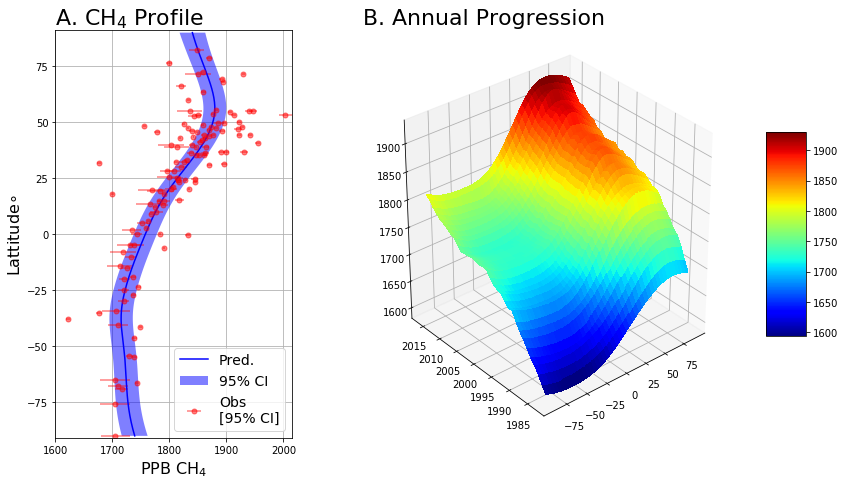

Minima:  1715.32601734  at:  [[-38.]]  ${\circ}$
Maxima:  1879.62885976  at:  [[ 56.]]  ${\circ}$


In [1432]:
Lat_Profile,Lat_Profile_yr = Profile(CH4)

kernel_CH4 = C(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
+ WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))

Preds = []
for year in range(Lat_Profile_yr.shape[1]-1):
    key = np.where(np.isnan(Lat_Profile_yr['std'][:,year])==False)
    if len(key[0]) > 1: 
        Lat,pred,sigma = Interp(Lat_Profile_yr[key[0],year],kernel_CH4,alpha=0,plot=False)
        Preds.append(pred)
Surface = np.asanyarray(Preds)
Year = np.arange(1983,2017,1)
X,Y = np.meshgrid(Lat,Year)

Lat,pred,sigma = Interp(Lat_Profile,kernel_CH4,alpha=0,plot=False)
Plot_Profile(Lat_Profile,pred,sigma,Surface,X,Y,Year,ax1_xlim=[1600,2015],azim=230)


# GPR - 13CH4

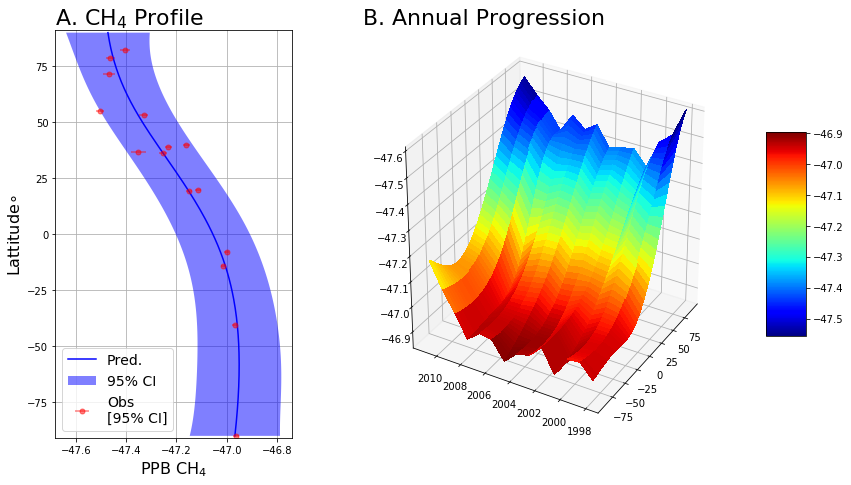

Minima:  -47.4727151716  at:  [[ 90.]]  ${\circ}$
Maxima:  -46.9504928533  at:  [[-58.]]  ${\circ}$


In [1434]:
Lat_Profile,Lat_Profile_yr = Profile(CH4_13)

kernel_13CH4 = C(1e0, (1e-1, 1e1))*Matern(1e0, (1e-3, 1e3),nu = 2.5)\
+ WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-5, 1e5))

Preds = []
for year in range(Lat_Profile_yr.shape[1]-1):
    key = np.where(np.isnan(Lat_Profile_yr['std'][:,year])==False)
    if len(key[0]) > 1: 
        Lat,pred,sigma = Interp(Lat_Profile_yr[key[0],year],kernel_13CH4,alpha=0,plot=False)
        Preds.append(pred)
Surface = np.asanyarray(Preds)
Year = np.arange(1998,2012,1)
X,Y = np.meshgrid(Lat,Year)
Lat,pred,sigma = Interp(Lat_Profile,kernel_13CH4,alpha=0,plot=False)
Plot_Profile(Lat_Profile,pred,sigma,Surface,X,Y,Year,ax1_loc='lower left',ax2_zlim=[-46.85,-47.6],azim=210)

# Fractination example

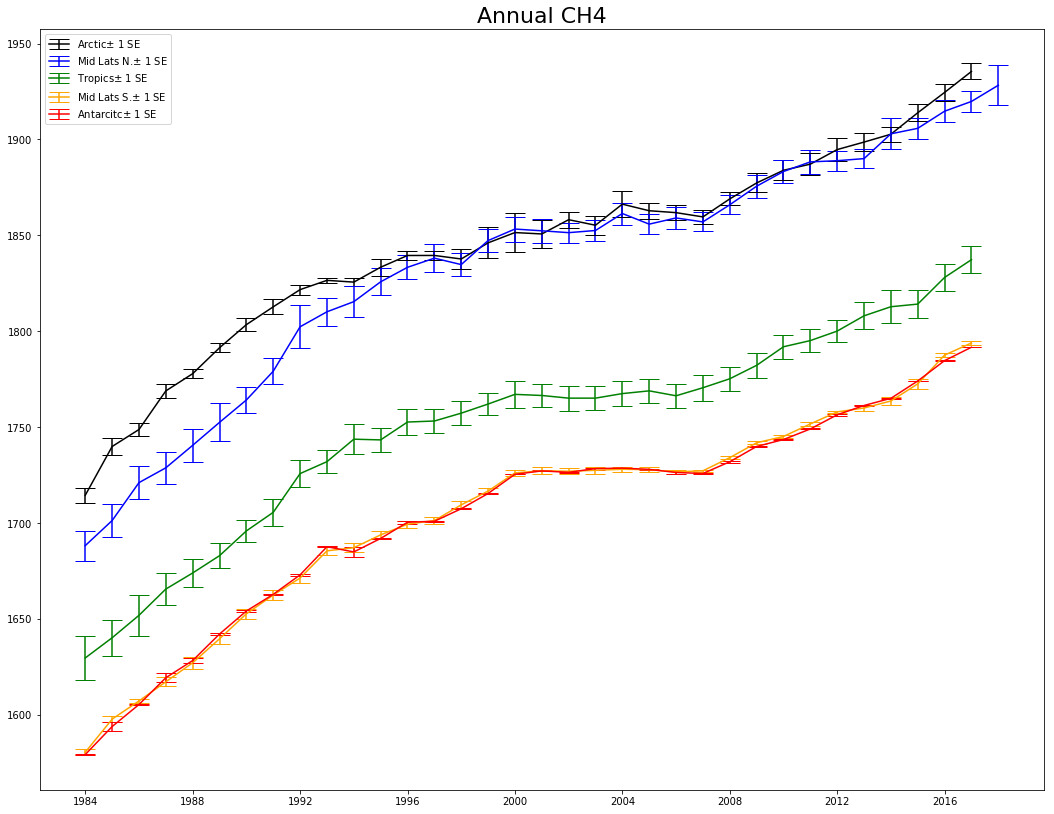

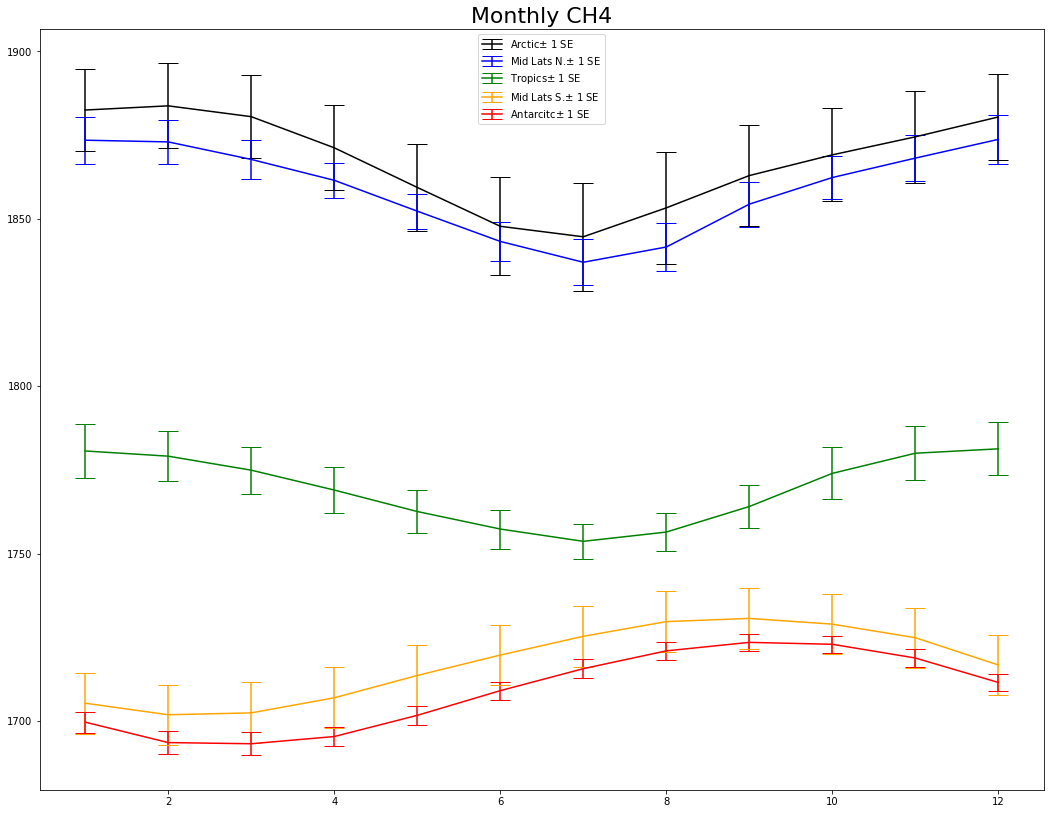

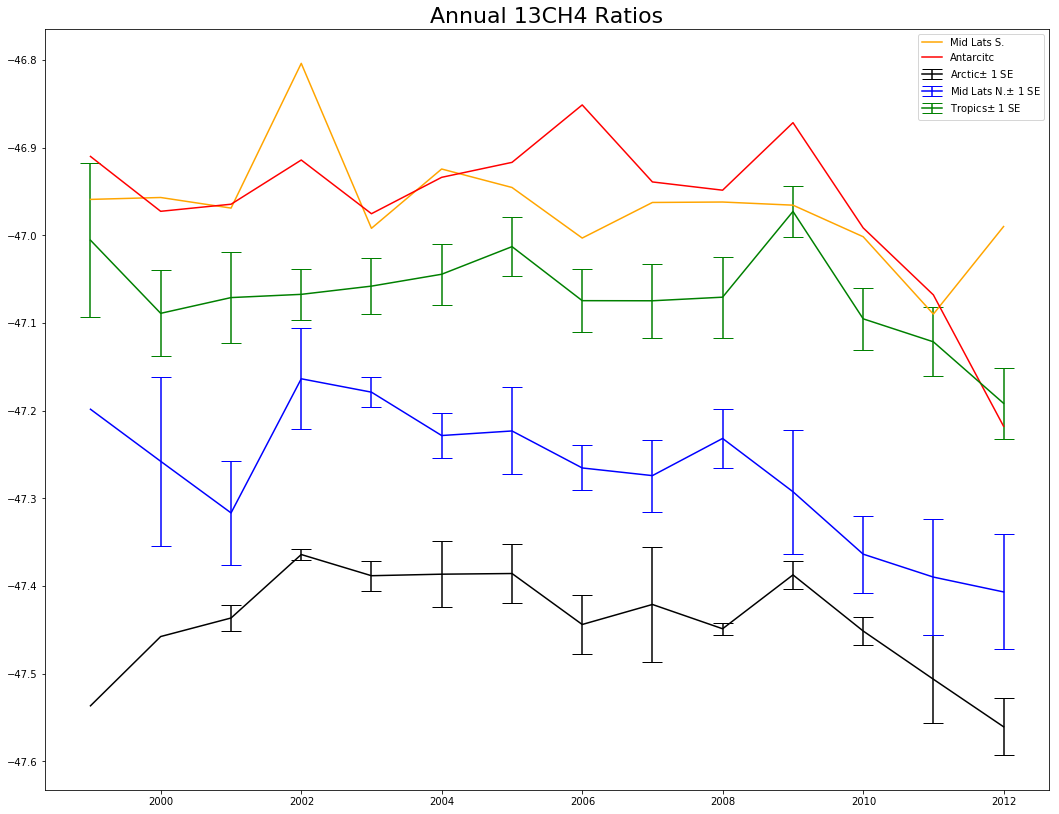

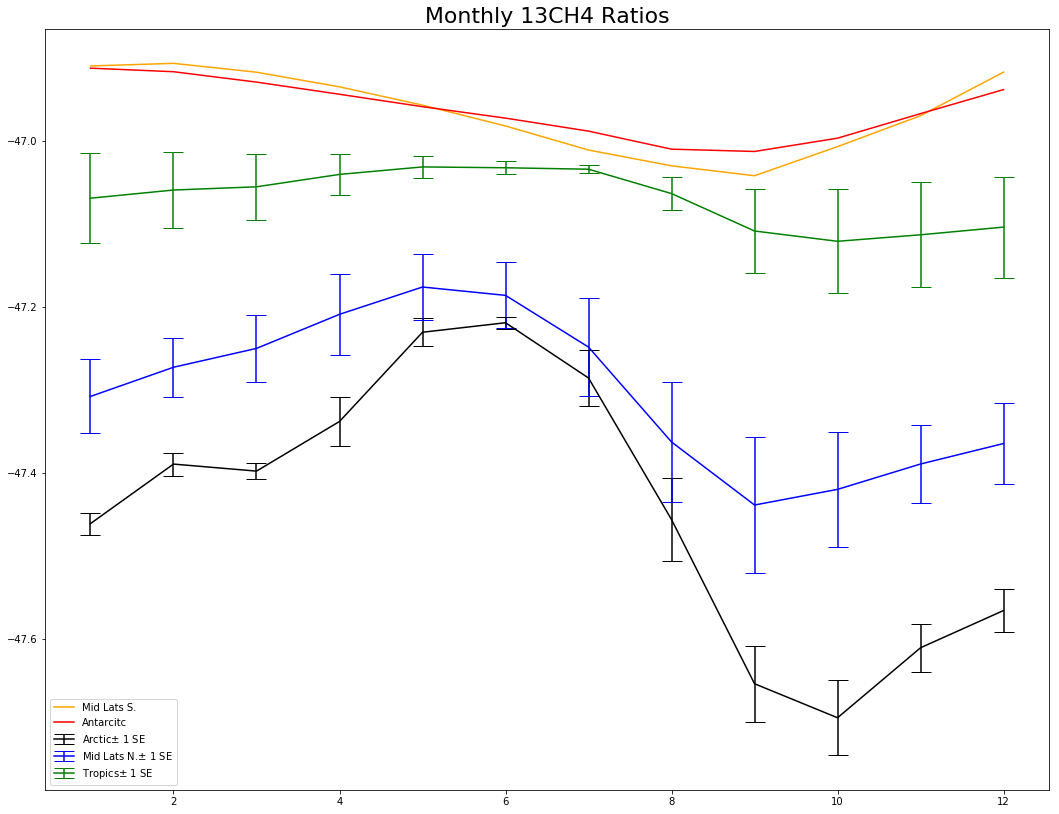

In [846]:

colors=['black','blue','green','orange','red']
labels=['Arctic','Mid Lats N.','Tropics','Mid Lats S.','Antarcitc']

Columns=[Arctic,Mid_Lats_N,Tropics,Mid_Lats_S,Antarctic]
title='Annual CH4'
Error_Bar_Plot(CH4.Yearly,Columns,colors,labels,title)

title='Monthly CH4'
Error_Bar_Plot(CH4.Monthly,Columns,colors,labels,title)

title='Annual 13CH4 Ratios'
Columns=[Arctic_13,Mid_Lats_N_13,Tropics_13,Mid_Lats_S_13,Antarctic_13]
Error_Bar_Plot(CH4_13.Yearly,Columns,colors,labels,title)

title='Monthly 13CH4 Ratios'
Error_Bar_Plot(CH4_13.Monthly,Columns,colors,labels,title)